# FYC
## TP : Modification de la lumière sur une photo portrait

Tout d'abord, importons les librairies.

In [1]:
import sys
import os 

import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision.utils import make_grid

import cv2
import pandas as pd

from IPython.display import Image, display
from model.defineHourglass_512_gray_skip import *


from utils.utils_SH import *















Une fois les librairies importées, nous allons maintenant générer notre normal pour l'assossier à notre Harmonique Sphèrique

In [2]:

img_size = 256
x = np.linspace(-1 , 1 , img_size )
z = np.linspace(-1 , 1 , img_size )

x , z = np.meshgrid(x , z)

mag = np.sqrt(x**2 + z**2)

valid = mag <= 1

y = -np.sqrt(1- (x * valid)**2 - (z*valid) ** 2)

x = x * valid
y = y * valid
z = z * valid

normal = np.concatenate((x[...,None], y[...,None] , z[...,None]) , axis = 2)
normal = np.reshape(normal, (-1 ,3))

myDisplay = pd.DataFrame(normal)
myDisplay





















,0,1,2
0,-0.0,-0.0,-0.0
1,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0
...,...,...,...
65531,0.0,-0.0,0.0
65532,0.0,-0.0,0.0
65533,0.0,-0.0,0.0
65534,0.0,-0.0,0.0


### Chargement du Model

Notre normal est prête nous allons maintenant charger notre model :

In [3]:
modelFolder = "trained_model/"
lightFolder = "data/example_light/"
saveFolder = "result"

my_network = HourglassNet()
my_network.load_state_dict(torch.load(os.path.join(modelFolder, 'trained_model_03.t7')))
my_network.cuda()
my_network.train(False)

if not os.path.exists(saveFolder) :
    os.makedirs(saveFolder)



### Insersion de l'image :

Bien Maintenant que notre model est chargé nous pouvons maintenant charger notre image ! 

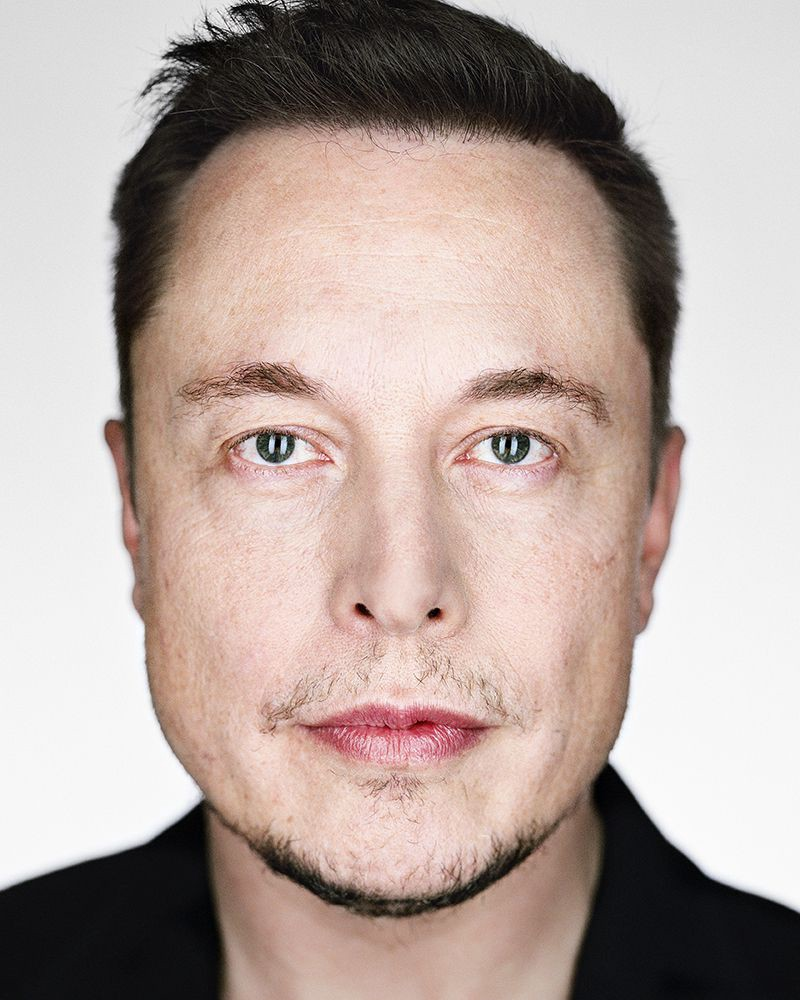

In [4]:



img_path = "data/elonmusk.jpg"
display(Image(filename=img_path))

img = cv2.imread(img_path)






















Préparation de l'image :

In [5]:
row, col, _  = img.shape
img = cv2.resize(img, (512,512))

Lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

cv2.imshow('image', Lab)
cv2.waitKey(0)



-1

In [6]:














inputL = Lab[:,:,0]
inputL = inputL.astype(np.float32)/255.0


inputL = inputL.transpose((0,1))
inputL = inputL[None,None,...]
inputL = Variable(torch.from_numpy(inputL).cuda())













Generation des nouvelles images : 

In [7]:
#Range : 7
RANGE = 4
for i in range(RANGE):
    sh = np.loadtxt(os.path.join(lightFolder, 'rotate_light_{:02d}.txt'.format(i)))
    sh = sh[0:9]
    sh = sh * 0.7 #Attenuer

    #--------------------------------------------------
    # rendering half-sphere
    sh = np.squeeze(sh)
    shading = get_shading(normal, sh)

    
    value = np.percentile(shading, 95)
    ind = shading > value
    shading[ind] = value
    
    shading = (shading - np.min(shading))/(np.max(shading) - np.min(shading))
    shading = (shading *255.0).astype(np.uint8)
   
    shading = np.reshape(shading, (256, 256))
    shading = shading * valid
    

    cv2.imwrite(os.path.join(saveFolder, 'light_{:02d}.png'.format(i)), shading)
  
    sh = np.reshape(sh, (1,9,1,1)).astype(np.float32)
    sh = Variable(torch.from_numpy(sh).cuda())
    
    outputImg, outputSH = my_network(inputL, sh, 0)
    outputImg = outputImg[0].cpu().data.numpy()
    outputImg = outputImg.transpose((1,2,0))
    outputImg = np.squeeze(outputImg)
    outputImg = (outputImg *255.0).astype(np.uint8)
    
    Lab[:,:,0] = outputImg
    
    resultatLab = cv2.cvtColor(Lab, cv2.COLOR_LAB2BGR)
    resultatLab = cv2.resize(resultatLab, (col, row))
    cv2.imwrite(os.path.join(saveFolder, 'elonmusk{:02}.jpg'.format(i)), resultatLab)
    



### Harmonic Sphérique

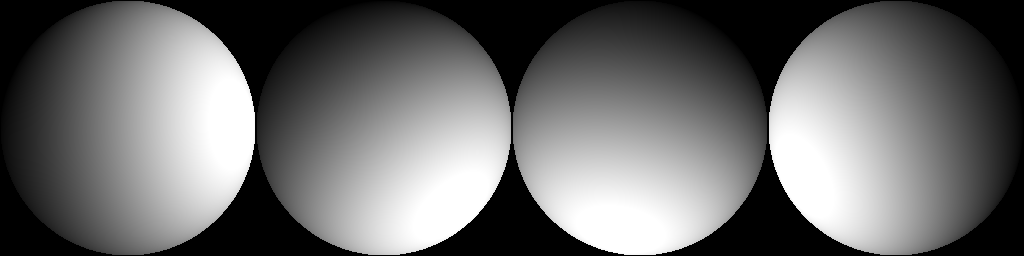

In [8]:
harmonic_spherics = []

for i in range (RANGE) :
    new_path = os.path.join(saveFolder, 'light_{:02}.png'.format(i))
    
    new_harmonic_spheric = cv2.imread(new_path)
    
    harmonic_spherics.append(new_harmonic_spheric)
    
final_frame_hs = cv2.hconcat(harmonic_spherics)
path_final_frame_hs = os.path.join(saveFolder, 'lights.png')
cv2.imwrite(path_final_frame_hs, final_frame_hs)


display(Image(filename = path_final_frame_hs) )


















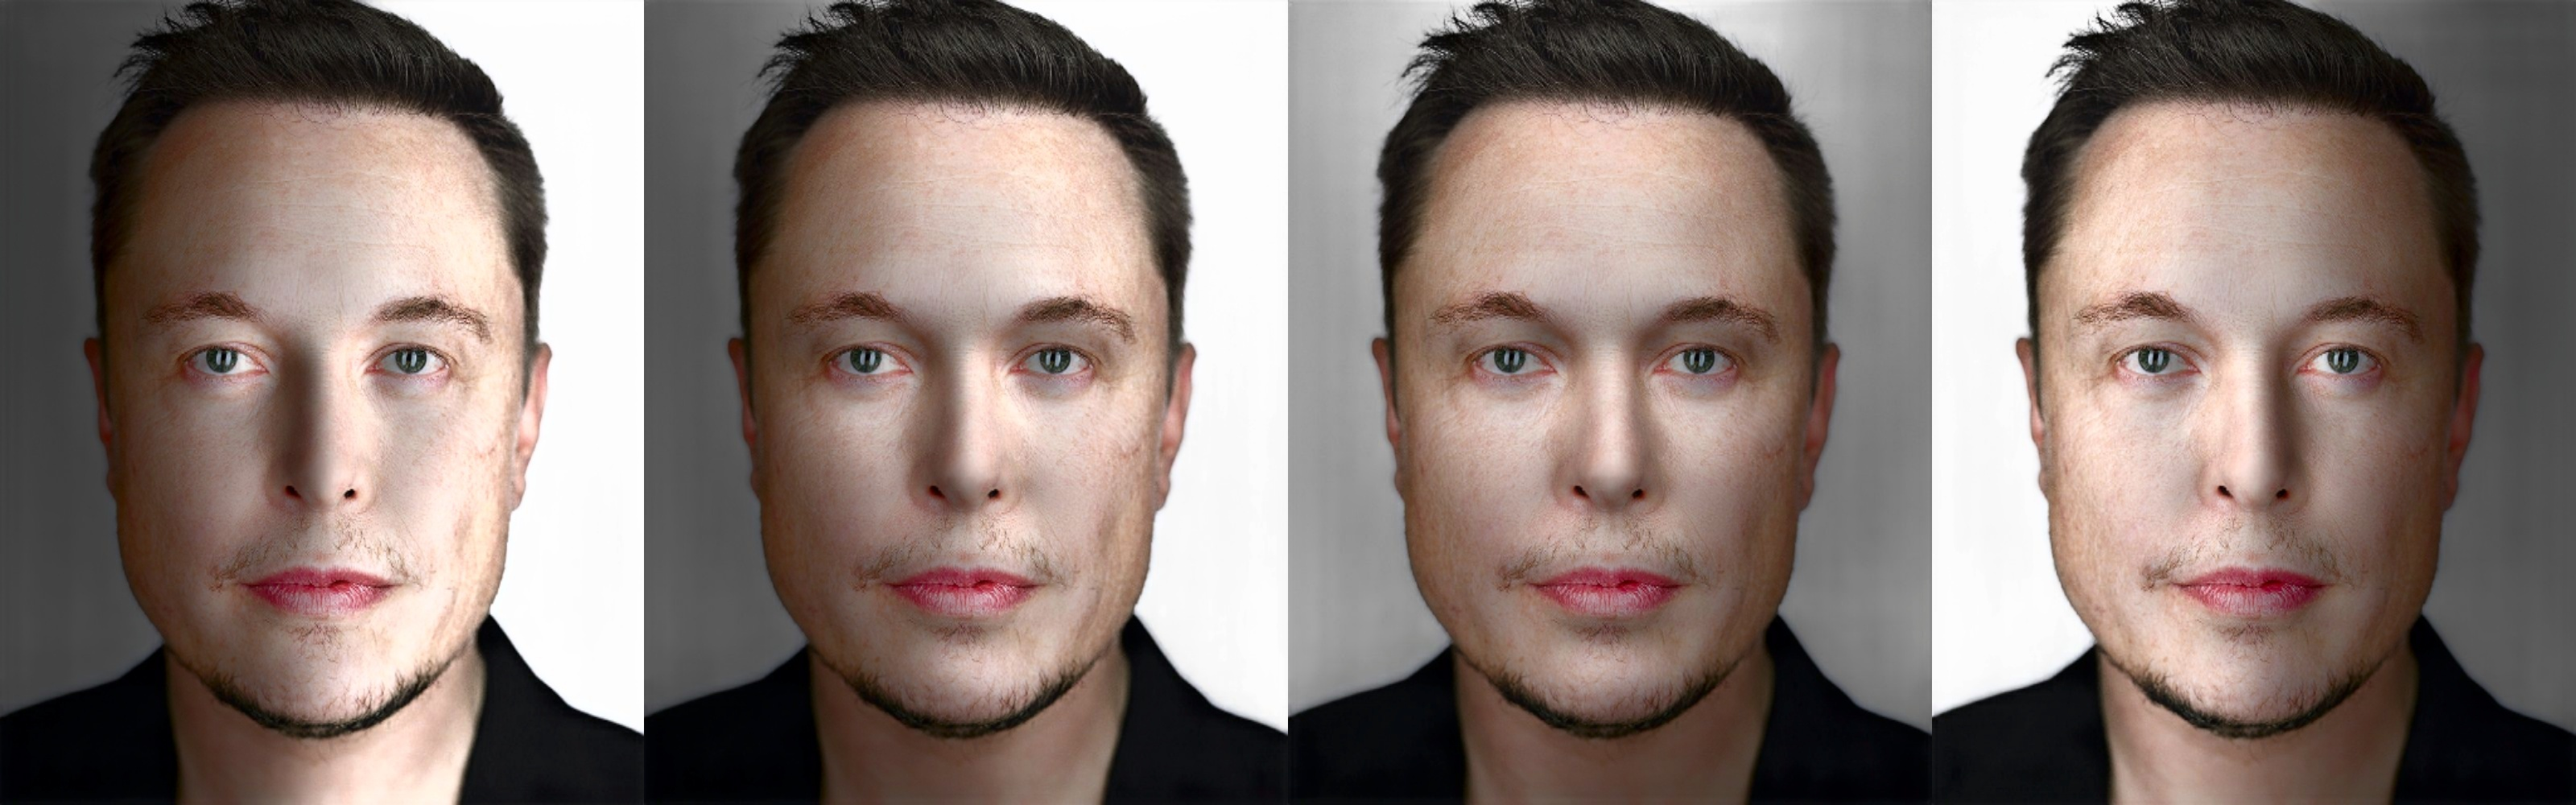

In [9]:





























images = []

for i in range (RANGE) :
    new_path = os.path.join(saveFolder, 'elonmusk{:02}.jpg'.format(i))
    
    new_image = cv2.imread(new_path)
    
    images.append(new_image)
    
final_frame = cv2.hconcat(images)
path_final_frame = os.path.join(saveFolder, 'leselonmusk.jpg')
cv2.imwrite(path_final_frame, final_frame)


display(Image(filename = path_final_frame) )





























